In [7]:
import pandas as pd
import numpy as np

In [25]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

y_train = train_data['label']
x_train = train_data.drop('label', axis=1)
y_test = test_data['label']
x_test = test_data.drop('label', axis=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [26]:
# Get data as numpy arrays and reshape it
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

x_train = np.reshape(x_train, (60000, 28, 28))
x_test = np.reshape(x_test, (10000, 28, 28))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [27]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import keras.datasets.fashion_mnist as fashion_mnist

def preprocess_data(x_train, y_train_1, x_test, y_test_1):
    
    n_class_1 = 10
    
    y_train_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in y_train_1)
    y_test_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in y_test_1)
    
    n_class_2 = 3
    
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
    y_train_1 = to_categorical(y_train_1, n_class_1)
    y_test_1 = to_categorical(y_test_1, n_class_1)
    y_train_2 = to_categorical(y_train_2, n_class_2)
    y_test_2 = to_categorical(y_test_2, n_class_2)
    
    return x_train, y_train_1, y_train_2, x_test, y_test_1, y_test_2

x_train, y_train_1, y_train_2, x_test, y_test_1, y_test_2 = preprocess_data(x_train, y_train, x_test, y_test)

print(x_train.shape)
print(y_train_1.shape)
print(y_train_2.shape)
print(x_test.shape)
print(y_test_1.shape)
print(y_test_2.shape)

(60000, 28, 28, 1)
(60000, 10)
(60000, 3)
(10000, 28, 28, 1)
(10000, 10)
(10000, 3)


In [53]:
# Build model

def generate_model(gamma):

    inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='input')

    main_branch = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1)(inputs)
    main_branch = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(main_branch)
    main_branch = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1)(main_branch)
    main_branch = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(main_branch)
    main_branch = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1)(main_branch)
    main_branch = tf.keras.layers.Flatten()(main_branch)
    main_branch = tf.keras.layers.Dense(3136, activation='relu')(main_branch)

    task_1_branch = tf.keras.layers.Dense(1024, activation='relu')(main_branch)
    task_1_branch = tf.keras.layers.Dense(100, activation='relu')(task_1_branch)
    task_1_branch = tf.keras.layers.Dense(10, activation='softmax', name='task_1_output')(task_1_branch)


    task_2_branch = tf.keras.layers.Dense(1024, activation='relu')(main_branch)
    task_2_branch = tf.keras.layers.Dense(100, activation='relu')(task_2_branch)
    task_2_branch = tf.keras.layers.Dense(3, activation='softmax', name='task_2_output')(task_2_branch)

    model = tf.keras.Model(inputs = inputs, outputs = [task_1_branch, task_2_branch])

    model.compile(optimizer='adam',
                  loss={'task_1_output': 'categorical_crossentropy', 'task_2_output': 'categorical_crossentropy'},
                  loss_weights={'task_1_output': gamma, 'task_2_output': 1 - gamma}, metrics=['accuracy'])
    
    return model


In [61]:
def fit_batch(gamma_values):
    
    history = list()
    
    for gamma in gamma_values:
        
        print('Training model for gamma equal to ', gamma)
        model = generate_model(gamma)
        model_history = model.fit({'input': x_train},
                            {'task_1_output': y_train_1, 'task_2_output': y_train_2},
                            epochs=10, batch_size=128, verbose=0)
        history.append(model_history)
        
    return history
        

In [79]:
gammas = [0., 0.11, 0.33, 0.5, 0.67, 0.89, 1.]
training_history = fit_batch(gammas)

Training model for gamma equal to  0.0
Training model for gamma equal to  0.11
Training model for gamma equal to  0.33
Training model for gamma equal to  0.5
Training model for gamma equal to  0.67
Training model for gamma equal to  0.89
Training model for gamma equal to  1.0



Plotting Accuracy vs Epochs for each value of gamma

High values of gamma means that the model weights more the loss of Task 1, whereas low values mean that it weights more the loss of Task 2

Plotting Accuracy vs Epochs for value of gamma number 0.0



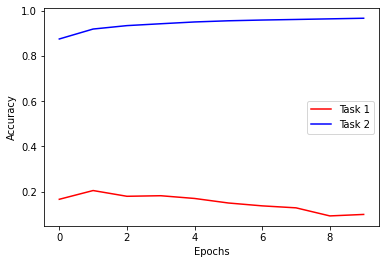


Plotting Accuracy vs Epochs for value of gamma number 0.11



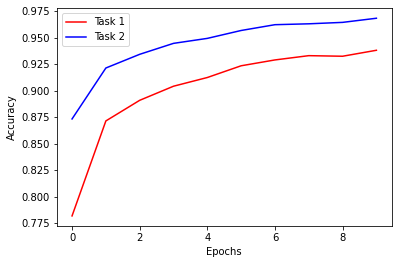


Plotting Accuracy vs Epochs for value of gamma number 0.33



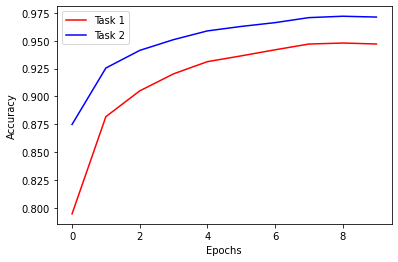


Plotting Accuracy vs Epochs for value of gamma number 0.5



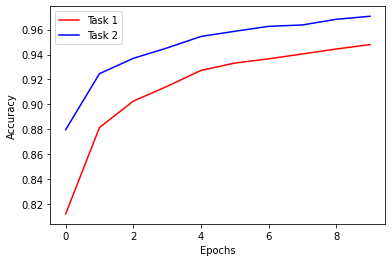


Plotting Accuracy vs Epochs for value of gamma number 0.67



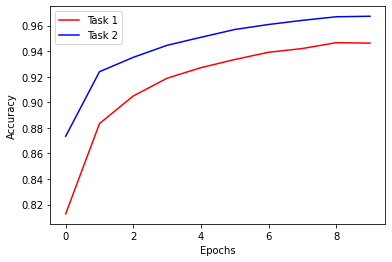


Plotting Accuracy vs Epochs for value of gamma number 0.89



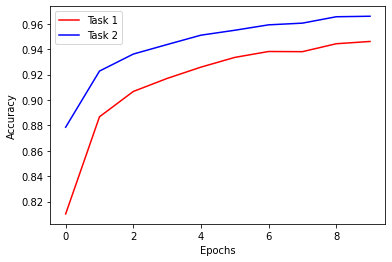


Plotting Accuracy vs Epochs for value of gamma number 1.0



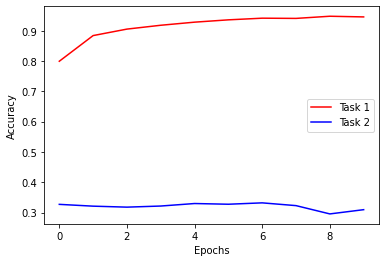

In [80]:
import matplotlib.pyplot as plt

print('\nPlotting Accuracy vs Epochs for each value of gamma\n')
print('High values of gamma means that the model weights more the loss of Task 1, '
      'whereas low values mean that it weights more the loss of Task 2')
counter = 0

for history in training_history:
    
    print(f'\nPlotting Accuracy vs Epochs for value of gamma number {gammas[counter]}\n')
    plt.plot(range(len(history.history['task_1_output_accuracy'])), history.history['task_1_output_accuracy'], c='r', label='Task 1')
    plt.plot(range(len(history.history['task_2_output_accuracy'])), history.history['task_2_output_accuracy'], c='b', label='Task 2')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    counter += 1
    